In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as function
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import pytorch_lightning as pl


In [2]:
torch.manual_seed(42)
batch_size = 128
avail_gpu = min(1, torch.cuda.device_count())
num_workers = int(os.cpu_count()/2)

In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=batch_size, num_worker=num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size= batch_size
        self.num_workers = num_workers
        
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        
    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
            
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000]) 
                
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
                
    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)
        
    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)
        
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)
            

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = function.relu(function.max_pool2d(self.conv1(x), 2))
        x = function.relu(function.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = function.relu(self.fc1(x))
        x = function.dropout(x, training=self.training)
        x = function.relu(self.fc2(x))
        return torch.sigmoid(x)

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)
        self.convt1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
        self.convt2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
        self.conv = nn.Conv2d(16, 1, kernel_size=7)
        
    def forward(self, x):
        x = self.lin1(x)
        x = function.relu(x)
        x = x.view(-1, 64, 7, 7)
        x = self.convt1(x)
        x = function.relu(x)
        x = self.convt2(x)
        x = function.relu(x)
        return self.conv(x)
        
        

In [6]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, learning_rate=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        self.validation_z = torch.randn(6, self.hparams.latent_dim)
        self.automatic_optimization = False
        
    def forward(self, z):
        return self.generator(z)
    
    def adversial_loss(self, y_, y):
        return function.binary_cross_entropy(y_, y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)
        
        if optimizer_idx == 0:
            fake_imgs = self(z)
            y_ = self.discriminator(fake_imgs)
             
            y = torch.ones(real_imgs.size(0), 1)
            y = y.type_as(real_imgs)
             
            g_loss = self.adversial_loss(y_, y)
            log_dict = {"g_loss": g_loss}
            return {"loss": g_loss, "progress_bar": log_dict, "log": log_dict}
         
        if optimizer_idx == 1:
            y_real = self.discriminator(real_imgs)
            yreal = torch.ones(real_imgs.size(0), 1)
            yreal = yreal.type_as(real_imgs)
            
            real_loss = self.adversial_loss(y_real, yreal)
            
            y_fake = self.discriminator(self(z).detach())
            yfake = torch.zeros(real_imgs.size(0), 1)
            yfake = yfake.type_as(real_imgs)
            
            fake_loss = self.adversial_loss(y_fake, yfake)
            
            d_loss = (real_loss + fake_loss)/2         
            log_dict = {"d_loss": d_loss}
            return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict}             
    
    
    def configure_optimizers(self):
        learning_rate = self.hparams.learning_rate
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate)
        return [opt_g, opt_d], []
    
    def plot_image(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_images = self(z).cpu()
        print("epoch", self.current_epoch)
        fig = plt.figure()
        for i in range(sample_images.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_images.detach()[i, 0, :, :], cmap="gray_r", interpolation="none")
            plt.title("Generated data")
            plt.xticks([])
            plt.yticks([])
            plt.axis("off")
        plt.show()
    
    def on_epoch_end(self):
        self.plot_image()
        

In [7]:
dm = MNISTDataModule()
model = GAN()


epoch 0


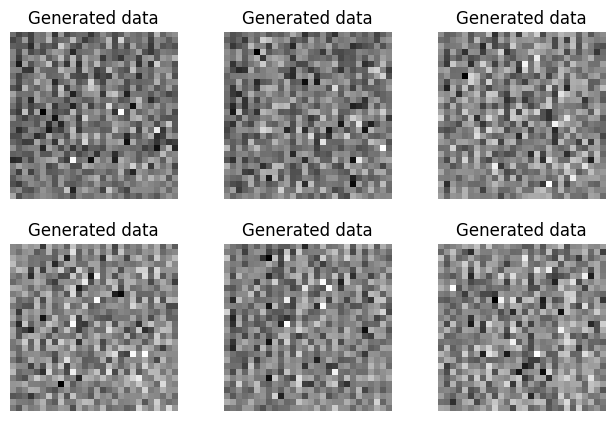

In [8]:
model.plot_image()

In [9]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, dm)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:35<00:00, 282762.89it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 89001.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:05<00:00, 314639.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 480988.94it/s]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training: 0it [00:00, ?it/s]

ValueError: Your `LightningModule.training_step` signature contains an `optimizer_idx` argument but in manual optimization optimizers must be handled by the user. Remove the optimizer_idx argument or set `self.automatic_optimization = True`.